# Unit 4 Exercise 1: Finding sensor anomalies for a water company

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
water_df = pd.read_csv(
    'drive/MyDrive/Terminal34/sensor.csv', parse_dates=['timestamp'], index_col='timestamp')
water_df.head()

,Unnamed: 0,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,0,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:01:00,1,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:02:00,2,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
2018-04-01 00:03:00,3,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
2018-04-01 00:04:00,4,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [6]:
water_df.sensor_00.min(), water_df.sensor_00.max(), water_df.sensor_00.median()

(0.0, 2.549016, 2.456539)

In [7]:
water_df.describe()

,Unnamed: 0,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,220320.000000,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,215213.000000,...,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,143303.000000,204937.000000
mean,110159.500000,2.372221,47.591611,50.867392,43.752481,590.673936,73.396414,13.501537,15.843152,15.200721,...,35.453455,43.879591,42.656877,43.094984,48.018585,44.340903,150.889044,57.119968,183.049260,202.699667
std,63601.049991,0.412227,3.296666,3.666820,2.418887,144.023912,17.298247,2.163736,2.201155,2.037390,...,10.259521,11.044404,11.576355,12.837520,15.641284,10.442437,82.244957,19.143598,65.258650,109.588607
min,0.000000,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,...,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779
25%,55079.750000,2.438831,46.310760,50.390620,42.838539,626.620400,69.976260,13.346350,15.907120,15.183740,...,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,167.534700,179.108800
50%,110159.500000,2.456539,48.133678,51.649300,44.227428,632.638916,75.576790,13.642940,16.167530,15.494790,...,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,193.865700,197.338000
75%,165239.250000,2.499826,49.479160,52.777770,45.312500,637.615723,80.912150,14.539930,16.427950,15.697340,...,36.979164,46.614580,45.138890,44.849540,51.215280,46.585650,208.333300,60.763890,219.907400,216.724500
max,220319.000000,2.549016,56.727430,56.032990,48.220490,800.000000,99.999880,22.251160,23.596640,24.348960,...,374.218800,408.593700,1000.000000,320.312500,370.370400,303.530100,561.632000,464.409700,1000.000000,1000.000000


In [8]:
water_df = water_df.drop(['Unnamed: 0'], axis=1)
water_df.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [9]:
water_df.isna().any(axis=1)

timestamp
2018-04-01 00:00:00    True
2018-04-01 00:01:00    True
2018-04-01 00:02:00    True
2018-04-01 00:03:00    True
2018-04-01 00:04:00    True
                       ... 
2018-08-31 23:55:00    True
2018-08-31 23:56:00    True
2018-08-31 23:57:00    True
2018-08-31 23:58:00    True
2018-08-31 23:59:00    True
Length: 220320, dtype: bool

In [10]:
water_df = water_df.fillna(water_df.median())
water_df.head()

<ipython-input-10-1d123353db3b>:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  water_df = water_df.fillna(water_df.median())


,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [11]:
water_df.median()

<ipython-input-11-b63f57b30648>:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  water_df.median()


sensor_00      2.456539
sensor_01     48.133678
sensor_02     51.649300
sensor_03     44.227428
sensor_04    632.638916
sensor_05     75.576790
sensor_06     13.642940
sensor_07     16.167530
sensor_08     15.494790
sensor_09     15.082470
sensor_10     44.291340
sensor_11     45.363140
sensor_12     32.515830
sensor_13      2.929809
sensor_14    420.106200
sensor_15           NaN
sensor_16    462.856100
sensor_17    462.020250
sensor_18      2.533704
sensor_19    665.672400
sensor_20    399.367000
sensor_21    879.697600
sensor_22    531.855900
sensor_23    981.925000
sensor_24    625.873500
sensor_25    740.203500
sensor_26    861.869600
sensor_27    494.468450
sensor_28    967.279850
sensor_29    564.872500
sensor_30    668.981400
sensor_31    917.708300
sensor_32    878.850750
sensor_33    512.271750
sensor_34    226.356050
sensor_35    473.349350
sensor_36    709.668050
sensor_37     64.295485
sensor_38     49.479160
sensor_39     35.416660
sensor_40     66.406250
sensor_41     34

In [12]:
water_df.mean()

<ipython-input-12-0dba4cb063be>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  water_df.mean()


sensor_00      2.376127
sensor_01     47.592519
sensor_02     50.867460
sensor_03     43.752522
sensor_04    590.677555
sensor_05     73.396602
sensor_06     13.504617
sensor_07     15.851177
sensor_08     15.207538
sensor_09     14.805117
sensor_10     41.470582
sensor_11     41.918616
sensor_12     29.137266
sensor_13      7.078500
sensor_14    376.864163
sensor_15           NaN
sensor_16    416.479418
sensor_17    421.136055
sensor_18      2.303833
sensor_19    590.835210
sensor_20    360.807966
sensor_21    796.232004
sensor_22    459.806225
sensor_23    922.613572
sensor_24    556.240454
sensor_25    649.159678
sensor_26    786.418631
sensor_27    501.506078
sensor_28    851.698733
sensor_29    576.191604
sensor_30    614.660868
sensor_31    863.327050
sensor_32    804.306929
sensor_33    486.407858
sensor_34    234.971151
sensor_35    427.133173
sensor_36    593.042346
sensor_37     60.787615
sensor_38     49.655925
sensor_39     36.610298
sensor_40     68.844231
sensor_41     35

In [13]:
water_df.isna().any(axis=1)

timestamp
2018-04-01 00:00:00    True
2018-04-01 00:01:00    True
2018-04-01 00:02:00    True
2018-04-01 00:03:00    True
2018-04-01 00:04:00    True
                       ... 
2018-08-31 23:55:00    True
2018-08-31 23:56:00    True
2018-08-31 23:57:00    True
2018-08-31 23:58:00    True
2018-08-31 23:59:00    True
Length: 220320, dtype: bool

In [14]:
water_df.iloc[10]

sensor_00           2.46441
sensor_01          47.48264
sensor_02            53.125
sensor_03         46.397568
sensor_04          637.7314
sensor_05          76.05148
sensor_06          13.41146
sensor_07          16.16753
sensor_08          15.65393
sensor_09          15.11863
sensor_10          39.90199
sensor_11          50.48941
sensor_12          32.80076
sensor_13          1.678884
sensor_14           419.334
sensor_15               NaN
sensor_16          462.5085
sensor_17          464.5157
sensor_18          2.575479
sensor_19           661.137
sensor_20          398.3386
sensor_21          875.1385
sensor_22          497.4714
sensor_23           971.978
sensor_24          623.6445
sensor_25          746.0667
sensor_26          845.2891
sensor_27          447.1741
sensor_28          771.0511
sensor_29          706.3684
sensor_30          667.5926
sensor_31          751.0416
sensor_32          694.1971
sensor_33          460.4902
sensor_34          154.8265
sensor_35          3

In [15]:
water_df['sensor_15'].unique()

array([nan])

In [16]:
water_df = water_df.drop(['sensor_15'], axis=1)
water_df.iloc[0]

sensor_00          2.465394
sensor_01          47.09201
sensor_02           53.2118
sensor_03          46.31076
sensor_04           634.375
sensor_05          76.45975
sensor_06          13.41146
sensor_07          16.13136
sensor_08          15.56713
sensor_09          15.05353
sensor_10           37.2274
sensor_11          47.52422
sensor_12          31.11716
sensor_13          1.681353
sensor_14          419.5747
sensor_16          461.8781
sensor_17          466.3284
sensor_18          2.565284
sensor_19          665.3993
sensor_20          398.9862
sensor_21          880.0001
sensor_22          498.8926
sensor_23          975.9409
sensor_24           627.674
sensor_25          741.7151
sensor_26          848.0708
sensor_27          429.0377
sensor_28          785.1935
sensor_29          684.9443
sensor_30          594.4445
sensor_31          682.8125
sensor_32          680.4416
sensor_33          433.7037
sensor_34          171.9375
sensor_35          341.9039
sensor_36          1

In [17]:
# Standardize the data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(water_df.drop(['machine_status'], axis=1))
scaled_df.shape

(220320, 51)

## IQR

In [18]:
Q1 = water_df['sensor_00'].quantile(0.25)
Q3 = water_df['sensor_00'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detect outliers
outliers = water_df[(water_df['sensor_00'] < lower_bound) | (water_df['sensor_00'] > upper_bound)]
normal_data = water_df[(water_df['sensor_00'] >= lower_bound) & (water_df['sensor_00'] <= upper_bound)]

print("Outliers:\n", outliers.index.shape)
#print("\nNormal Data:\n", normal_data.head())

Outliers:
 (22523,)


In [19]:
# Function to detect outliers based on IQR
def detect_outliers_iqr(df):
    outlier_indices = []

    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Define bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Find the indices of outliers
        column_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index

        outlier_indices.extend(column_outliers)

    # Select unique indices
    outlier_indices = list(set(outlier_indices))

    print(outlier_indices[:5])

    #df.loc[outlier_indices]

    return df.loc[outlier_indices], df.drop(outlier_indices)

In [20]:
# Detect outliers
outliers, normal_data = detect_outliers_iqr(water_df.drop(['machine_status'], axis=1))

[Timestamp('2018-07-21 09:47:00'), Timestamp('2018-05-27 01:12:00'), Timestamp('2018-07-26 08:12:00'), Timestamp('2018-08-14 18:10:00'), Timestamp('2018-05-01 20:00:00')]


In [21]:
outliers.shape

(170255, 51)

## PCA

In [22]:
# Apply PCA
pca = PCA(n_components=2) # Reduce to 2 dimensions for visualization purposes
principal_components = pca.fit_transform(scaled_df)
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

In [23]:
principal_df.head()

,PC1,PC2
0,-0.024127,0.761067
1,-0.024127,0.761067
2,-0.164716,0.766021
3,-0.165260,0.798585
4,-0.120199,0.911922


In [24]:
principal_df.shape

(220320, 2)

In [25]:
principal_df['machine_status'] = water_df['machine_status'].values
principal_df.head()

,PC1,PC2,machine_status
0,-0.024127,0.761067,NORMAL
1,-0.024127,0.761067,NORMAL
2,-0.164716,0.766021,NORMAL
3,-0.165260,0.798585,NORMAL
4,-0.120199,0.911922,NORMAL


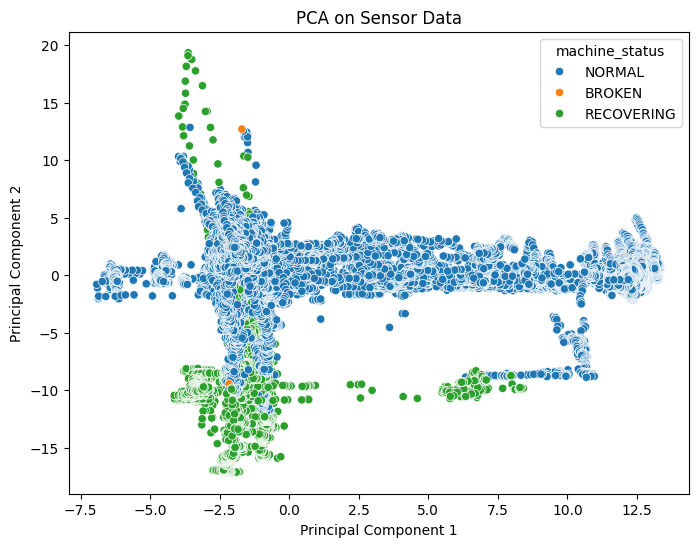

In [26]:
# Visualize the PCA output
plt.figure(figsize=(8, 6))
sns.scatterplot(data=principal_df, x='PC1', y='PC2', hue='machine_status')
plt.title('PCA on Sensor Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## KMeans

In [27]:
X = principal_df.drop(['machine_status'], axis=1)
X.head()

,PC1,PC2
0,-0.024127,0.761067
1,-0.024127,0.761067
2,-0.164716,0.766021
3,-0.165260,0.798585
4,-0.120199,0.911922


In [29]:
kmeans = KMeans(n_clusters=2, max_iter=1000).fit(X)
labels = kmeans.predict(X)
labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

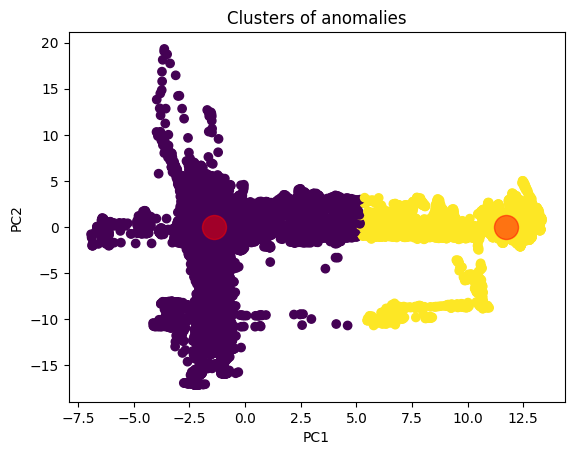

In [31]:
centroids = kmeans.cluster_centers_

plt.scatter(X['PC1'], X['PC2'], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', alpha=0.5)
plt.title('Clusters of anomalies')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

<ipython-input-38-0318be27fc1b>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


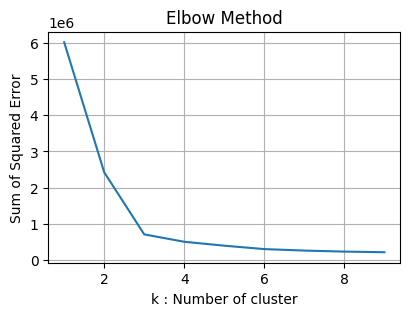

In [38]:
sse = {}
sil = []
kmax = 10
fig = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

# Elbow Method :
plt.subplot(1, 2, 1)
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000, n_init='auto').fit(X)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
sns.lineplot(x = list(sse.keys()), y = list(sse.values()));
plt.title('Elbow Method')
plt.xlabel("k : Number of cluster")
plt.ylabel("Sum of Squared Error")
plt.grid()

In [39]:
kmeans = KMeans(n_clusters=3, max_iter=1000).fit(X)
labels = kmeans.predict(X)
labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

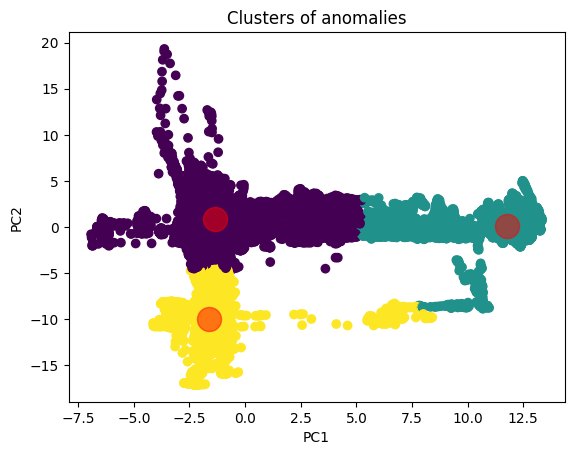

In [40]:
centroids = kmeans.cluster_centers_

plt.scatter(X['PC1'], X['PC2'], c=labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', alpha=0.5)
plt.title('Clusters of anomalies')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [41]:
kmeans = KMeans(n_clusters=3, max_iter=1000).fit(scaled_df)
labels = kmeans.predict(scaled_df)
labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [42]:
k_means_scaled_output = principal_df.copy()
k_means_scaled_output['predictions'] = labels

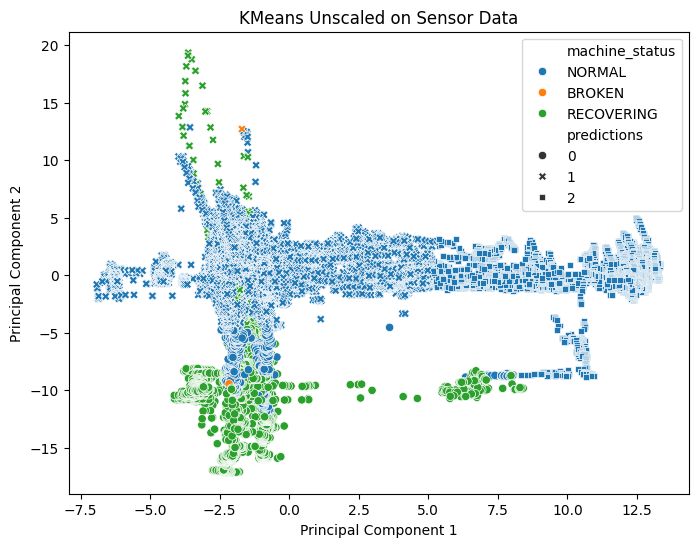

In [43]:
# Visualize the Isolation Forest output
plt.figure(figsize=(8, 6))
sns.scatterplot(data=k_means_scaled_output, x='PC1', y='PC2', hue='machine_status', style='predictions')
plt.title('KMeans Unscaled on Sensor Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Isolation Forest

In [22]:
# Initialize Isolation Forest
isolation_forest = IsolationForest(n_estimators=100, contamination=float(.001), random_state=42)

In [23]:
# Set dataset
X = principal_df.drop(['machine_status'], axis=1, errors='ignore')
X.head()

,PC1,PC2
0,-0.024127,0.761067
1,-0.024127,0.761067
2,-0.164716,0.766021
3,-0.165260,0.798585
4,-0.120199,0.911922


In [24]:
# Fit the model
isolation_forest.fit(X)

# Predict anomalies
scores_prediction = isolation_forest.decision_function(X)
y_pred = isolation_forest.predict(X)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [25]:
scores_prediction

array([0.28144325, 0.28144325, 0.29845742, ..., 0.31582829, 0.31860278,
       0.3179615 ])

In [27]:
np.unique(y_pred, return_counts=True)

(array([-1,  1]), array([   220, 220100]))

In [28]:
# Reshape the prediction values to 0 for non Anomaly or 1 to Anomaly.
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

In [29]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([220100,    220]))

In [30]:
X['machine_status'] = water_df['machine_status'].values
X['prediction'] = y_pred

In [31]:
X.head()

,PC1,PC2,machine_status,prediction
0,-0.024127,0.761067,NORMAL,0
1,-0.024127,0.761067,NORMAL,0
2,-0.164716,0.766021,NORMAL,0
3,-0.165260,0.798585,NORMAL,0
4,-0.120199,0.911922,NORMAL,0


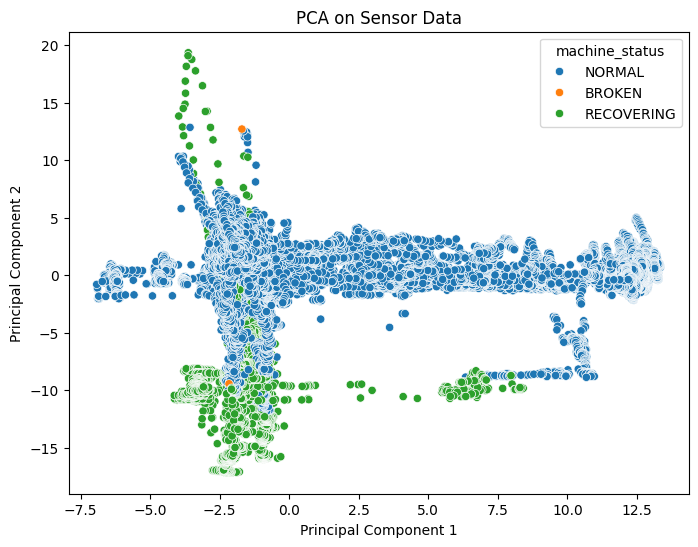

In [32]:
# Visualize the Isolation Forest output
plt.figure(figsize=(8, 6))
sns.scatterplot(data=X, x='PC1', y='PC2', hue='machine_status')
plt.title('PCA on Sensor Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

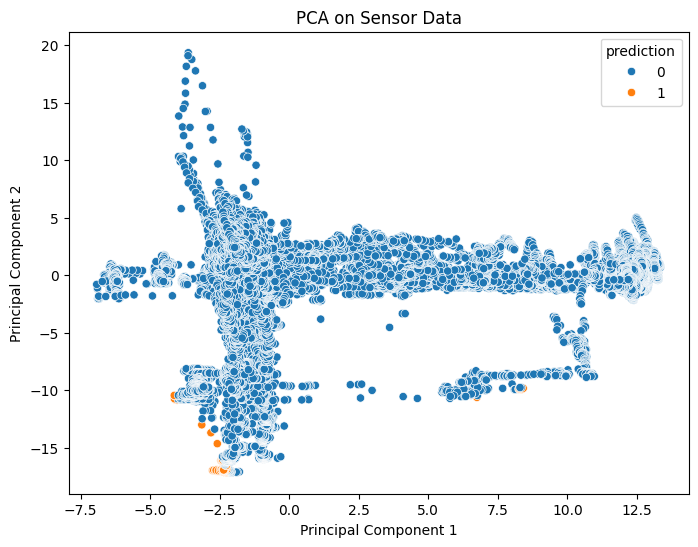

In [33]:
# Visualize the Isolation Forest output
plt.figure(figsize=(8, 6))
sns.scatterplot(data=X, x='PC1', y='PC2', hue='prediction')
plt.title('PCA on Sensor Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

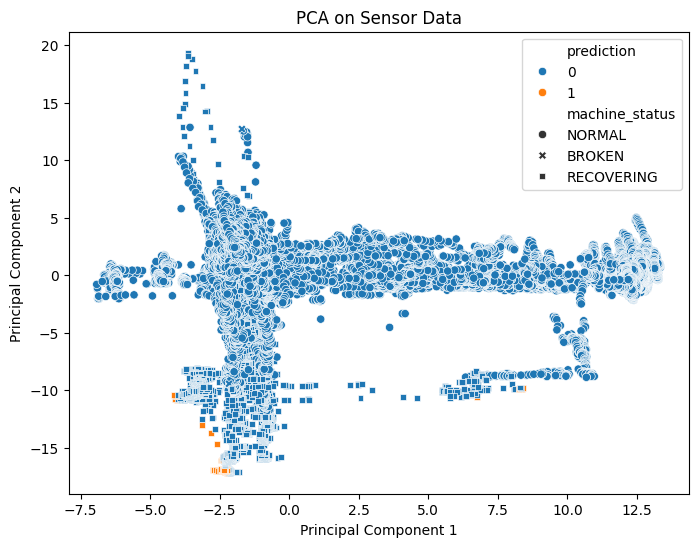

In [35]:
# Visualize the Isolation Forest output
plt.figure(figsize=(8, 6))
sns.scatterplot(data=X, x='PC1', y='PC2', style='machine_status', hue='prediction')
plt.title('PCA on Sensor Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

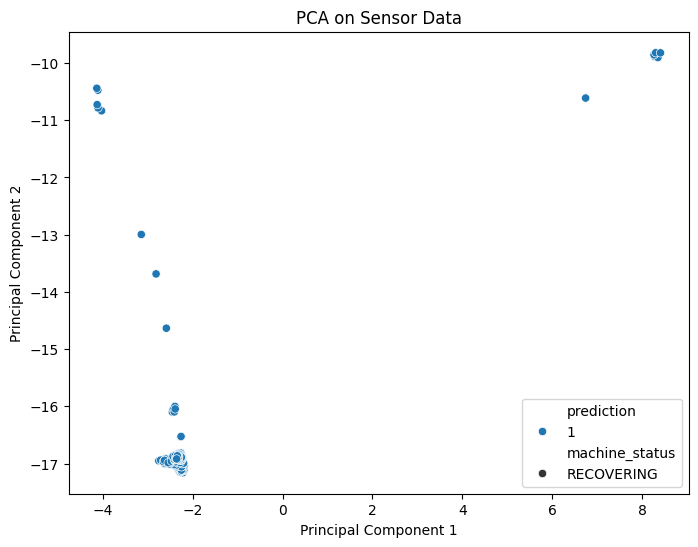

In [36]:
# Visualize the Isolation Forest output
plt.figure(figsize=(8, 6))
sns.scatterplot(data=X[X['prediction'] == 1], x='PC1', y='PC2', style='machine_status', hue='prediction')
plt.title('PCA on Sensor Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## DBSCAN

In [39]:
X.head()

,PC1,PC2,machine_status,prediction
0,-0.024127,0.761067,NORMAL,0
1,-0.024127,0.761067,NORMAL,0
2,-0.164716,0.766021,NORMAL,0
3,-0.165260,0.798585,NORMAL,0
4,-0.120199,0.911922,NORMAL,0


In [40]:
X = X.drop(['machine_status', 'prediction'], axis=1, errors='ignore')
X.head()

,PC1,PC2
0,-0.024127,0.761067
1,-0.024127,0.761067
2,-0.164716,0.766021
3,-0.165260,0.798585
4,-0.120199,0.911922


In [56]:
# Apply DBSCAN
dbscan = DBSCAN(eps=3, min_samples=10) # These parameters may need adjustment

In [57]:
clusters = dbscan.fit_predict(X[:200])
np.unique(clusters)

array([0])

In [58]:
clusters = dbscan.fit_predict(X[:20000])
np.unique(clusters)

array([0])

In [59]:
N_samples = 20000

In [ ]:
clusters = dbscan.fit_predict(X[:N_samples])
np.unique(clusters)

In [ ]:
# Add the cluster labels to the principal_df
principal_df_dbscan = X[:N_samples].copy()
principal_df_dbscan['cluster'] = clusters
principal_df_dbscan.head()

In [ ]:
# Visualize the Isolation Forest output
plt.figure(figsize=(8, 6))
sns.scatterplot(data=principal_df_dbscan, x='PC1', y='PC2', hue='cluster')
plt.title('DBSCAN on Sensor Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()